# Problem 1

In [1]:
%config InlineBackend.figure_format = 'svg'
from lestack import *
from solrel import biMorgen, siSet,rvSet, rvFunction, nataf, FORM

In [2]:
res = 100
rng = 4

### Given

In [3]:
mean1, std1 = 1200, 300
s = np.sqrt(np.log(std1**2/mean1**2+1))
mu = mean1**2/np.sqrt(std1**2+mean1**2)
X1 = scipy.stats.lognorm(s=s, scale=mu)
x1 = np.linspace(5,mean1+rng*std1,res)

In [4]:
mean2, std2 = 12, 4.8
X2 = scipy.stats.gamma(a=(mean2/std2)**(2), scale=(std2**2/mean2)**(1))
x2 = np.linspace(0.0001,mean2+rng*std2,res)

In [5]:
print(X1.mean(),' ',X1.std())
print(X2.mean(),' ',X2.std())

1200.0000000000002   300.00000000000006
12.0   4.8


In [6]:
rho= 0.0
Rxx  = np.array([[1, rho],[rho,1]])
_xx_ = rvSet(rvars=[X1,X2],Rxx=Rxx)

### Limit State

In [7]:
def func_x(x):
    theta = 0.5
    x1,x2 = x[0],x[1]
    return x1**theta - x2

def grad_x(x):
    theta = 0.5
    return np.array ([theta*x[0]**(theta-1),-1])

## Part a)

### i) Statistically Independent

In [8]:
XYi = siSet([X1,X2])
pi = FORM(XYi,func_x,grad_x)
pi.run()
pi.print_analysis()

0.11631404207873622
u*:    [-1.17147752  2.7697071 ]
x*:    [872.46499844  29.53751849]
alpha: [-6.77471945e-04  9.99999771e-01]
beta:  2.77050010514433
pf1:   0.002798514107265458


### ii) Nataf

In [9]:
rho = 0.5
Rxx  = np.array([[1, rho],[rho,1]])
def C(delj,deli,rho): 
    return 1.001 + 0.033*rho + 0.004*deli - 0.016*delj + 0.002*rho**2 + 0.223*deli**2 + 0.130*delj**2 + 0.029*delj*deli - 0.104*rho*deli - 0.119*rho*delj

XYii = nataf([X1,X2], Rxx, C)
pii = FORM(XYii,func_x,grad_x)
pii.run()
pii.print_analysis()

8.246625558320158
u*:    [0.26759251 3.80124488]
x*:    [1243.45781056   35.26269682]
alpha: [0.07023099 0.99753076]
beta:  3.810651968512857
pf1:   6.930038946618659e-05


### iii) Morgenstern

In [10]:
alpha = 1.0
XYiii = biMorgen(_xx_)
XYiii.alpha = lambda x: alpha
piii = FORM(XYiii,func_x,grad_x)
piii.run()
# print_result(piii)
piii.print_analysis()

10.199465835285308
u*:    [-0.39104853  3.21155401]
x*:    [1057.30689731   32.51625589]
alpha: [-0.39183578  0.92003517]
beta:  3.1079694573398666
pf1:   0.000941887675215332


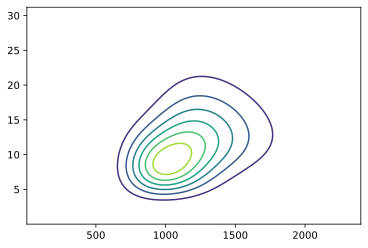

In [11]:
xx,yy = np.meshgrid(x1,x2)
plt.contour(xx,yy,XYiii.jpdf(xx,yy));

## Part b) 

In [12]:
u1 = u2 = np.linspace(-1,3,100)

In [13]:
def gsolve(x):
    f = lambda y: func_x([x,y])
    return scipy.optimize.fsolve(f,0)[0]
gi = [gsolve(x) for x in x1]

def Gsolve(u1):
    f = lambda u2: func_x(XYii.u_to_x([u1,u2]))
    return scipy.optimize.fsolve(f,0.001)[0]

Gi = [Gsolve(x) for x in u1]

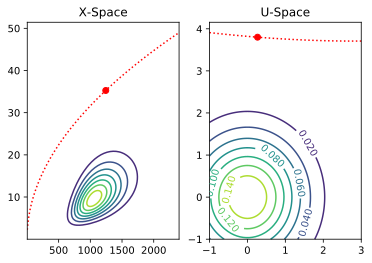

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2)

xx,yy = np.meshgrid(x1,x2)
zz = XYii.jpdf(xx,yy)
CS = ax1.contour(xx,yy,zz, extent=(x1[0], x1[-1], x2[0], x2[-1]))
# ax1.clabel(CS, inline=1, fontsize=10)
ax1.scatter(*pii.design_point_x,color='red')
ax1.set_title('X-Space')
ax1.plot(x1,gi, 'r:')

uu,vv = np.meshgrid(u1, u2)
pos = np.empty(uu.shape + (2,))
pos[:, :, 0] = uu
pos[:, :, 1] = vv
        
oo = scipy.stats.multivariate_normal.pdf(pos, np.zeros(2))
CS = ax2.contour(uu,vv,oo)
ax2.clabel(CS, inline=1, fontsize=10)
ax2.scatter(*pii.design_point_u,color='red')
ax2.set_title('U-Space');
ax2.plot(u1,Gi, 'r:');

# Appendix

In [15]:
class FORM:
    """First-Order Reliability Analysis"""
    def __init__(self, rvset, func_x, grad_x):
        self.rvset = rvset
        self.func_x = func_x
        self.grad_x = grad_x
        X = rvset
        self.func_u = lambda u: func_x(X.u_to_x(u))
        self.func_u.grad = lambda u: grad_x(X.u_to_x(u)).T @ X.Jxu(u)
        self.grad_u = lambda u: grad_x(X.u_to_x(u)).T @ X.Jxu(u)
    
    def run(self):
        G = self.func_u
        grad_u = self.grad_u
        ndim = len(self.rvset.rvset)

        def f(u):
            return scipy.linalg.norm(u)
        
        u = self.design_point_u = iHLRF(G,grad_u)
        alpha = -grad_u(u)/scipy.linalg.norm(grad_u(u))
        self.alpha = alpha
        self.design_point_x = self.rvset.u_to_x(u)
        self.beta = alpha@u
        return alpha@u

    def print_analysis(self):
        print('u*:    {}'.format(self.design_point_u))
        print('x*:    {}'.format(self.design_point_x))
        print('alpha: {}'.format(self.alpha))
        print('beta:  {}'.format(self.beta))
        print('pf1:   {}'.format(scipy.stats.norm.cdf(-self.beta)))

In [16]:

class mnSet(np.ndarray):
    """Multinormally distributed random variables"""
    def __new__(cls, rvars=None,data=None,Rxx=None,Sxx=None):
        if rvars is None: rvars = [None]
        if data is None: data = {'data':None}
        return np.asarray(rvars).view(cls)

    def __init__(self,rvars=None,data=None,Rxx=None,Sxx=None):
        if rvars is None:
            rvars = [None]
            self.__dict__ = data
            
        if data is None: 
            data = {'data':None}
            self.Rxx = Rxx
            self.Sxx = Sxx
            self.mean = np.array([x.mean() for x in rvars])
            self.std = np.array([x.std() for x in rvars])
        print('Rxx: ', self.Rxx)
        self.Dx = linalg.block_diag(*self.std)
        self.Dinv = np.linalg.inv(self.Dx)

        if hasattr(self,'Rxx') and not hasattr(self,'Sxx'):
            self.Sxx = self.Dx@(self.Rxx@self.Dx)
        if hasattr(self,'Sxx') and not hasattr(self,'Rxx'):
            self.Rxx = self.Dinv@self.Sxx@self.Dinv
        
        self.L = np.linalg.cholesky(self.Rxx)
        self.Linv = np.linalg.inv(self.L)
        self._Jxu = self.Dx@self.L

    def Jxu(self,u):
        return self._Jxu
    
    def Jux(self,x):
        return np.linalg.inv(self.Jxu)

    def __len__(self):
        return len(self.mean)

    def x_to_u(self,X):
        Linv, Dinv = self.Linv, self.Dinv
        U = Linv@Dinv@(X - self.mean)
        return U
    
    def u_to_x(self,U):
        Dx, L = self.Dx,self.L
        X = self.mean + Dx@L@U
        return X


class siSet(np.ndarray):
    """Statistically independent random variables"""
    def __new__(cls, rvset):
        return np.asarray(rvset).view(cls)

    def __init__(self, rvset):
        self.rvset = rvset
        n_dist = len(rvset)
        self.ndist = n_dist

        #  check if all distributions have finite moments
        for x in self.rvset:
            if (not((np.isfinite(x.mean()) and
                     np.isfinite(x.std())))):
                raise RuntimeError("The marginal distributions need to have "
                                   "finite mean and variance")


    def u_to_x(self,u):
        return np.array([X.ppf(stats.norm.cdf(u[i])) for i,X in enumerate(self.rvset)])
    
    def x_to_u(self,x):
        return np.array([stats.norm.ppf(X.cdf(x[i])) for i,X in enumerate(self.rvset)])
    
    def Jxu(self,u):
        X = self.rvset
        snorm = stats.norm.pdf
        d = np.identity(self.ndist)
        x = self.u_to_x(u)
        return np.array ([[X[i].pdf(x[i])/snorm(u[i])*d[i,j] for i in range(self.ndist)] for j in range(self.ndist)])
    
    def Jux(self,x):
        u = self.x_to_u(x)
        Jux = np.linalg.inv(self.Jxu(u))
        return Jux

    def jpdf(self,x,y):
        return 
    
class biMorgen(np.ndarray):
    """Morgenstern multivariate distribution"""
    def __new__(cls, rvset):
        return np.asarray(rvset).view(cls)
    
    def __init__(self, rvset):
        self.rvset = rvset
        self.correlations = rvset.Rxx
    
    def Qi(self,i):
        X = self.rvset[i]
        interval = X.interval(1)
        def f(x):
            return (x-X.mean())/X.std()*X.pdf(x)*X.cdf(x)
        return nquad(f,[interval])[0]
        
    def alpha(self,ij):
        Qi = self.Qi(ij[0])
        Qj = self.Qi(ij[1])
        return self.correlations[ij[0],ij[1]]/(4*Qi*Qj)
    
    def F2_1(self, x):
        X = self.rvset
        return X[1].cdf(x[1])*(1 + (1 - 2*X[0].cdf(x[0]))*(1 - X[1].cdf(x[1])))

    def f2_1 (self, x):
        X = self.rvset 
        return X[1].pdf(x[1])*(1 + (1 - 2*X[0].cdf(x[0]))*(1 - 2*X[1].cdf(x[1])))

    def u_to_x(self, u):
        X = self.rvset 
        x1 =  X[0].ppf(stats.norm.cdf(u[0]))
        def f(x2):
            return self.F2_1([x1,x2])-stats.norm.cdf(u[1])

        x2 = fsolve(f,0.01)[0]
        return np.array([x1,x2])

    def x_to_u(self,x):
        X = self.rvset 
        u1 = stats.norm.ppf(X[0].cdf(x[0]))
        u2 = stats.norm.ppf(self.F2_1(x))
        return np.array([u1,u2])

    def Jux(self,x):
        u = self.x_to_u(x)
        X = self.rvset
        Jux = np.zeros((2,2))

        Jux[0,0] = X[0].pdf(x[0])/stats.norm.pdf(u[0])
        Jux[0,1] = 0.0
        Jux[1,0] = -2*X[0].pdf(x[0])*X[1].cdf(x[1])*(1 - X[1].cdf(x[1]))
        Jux[1,1] = self.f2_1(x)/stats.norm.pdf(u[1])
        return Jux

    def Jxu(self,u):
        x = self.u_to_x(u)
        return np.linalg.inv(self.Jux(x))

    def jpdf(self,x,y):
        alpha12 = self.alpha([0,1])
        X = self.rvset
        return X[0].pdf(x) * X[1].pdf(y)*(1 + alpha12*(1-2*X[0].cdf(x))*(1-2*X[1].cdf(y)))
  
class nataf(np.ndarray):
    def __new__(cls, rvset, Rxx, C):
        return np.asarray(rvset).view(cls)

    def __init__(self, rvset, Rxx, C):
        self.rvset = rvset
        self.Rxx = Rxx
        self.C = C
        n_dist = len(rvset)
        self.ndist = n_dist

        #  check if all distributions have finite moments
        for x in self.rvset:
            if (not((np.isfinite(x.mean()) and
                     np.isfinite(x.std())))):
                raise RuntimeError("The marginal distributions need to have "
                                   "finite mean and variance")


        #  check if X the identiy
        self.Rzz = np.identity(n=n_dist)
        rho = self.Rxx[0,1]
        deli = self.rvset[0].std()/self.rvset[0].mean()
        delj = self.rvset[1].std()/self.rvset[1].mean()
        # C = 1.031+0.001*rho-0.007*delj+0.003*rho**2+0.131*delj**2-0.132*rho*delj
        self.Rzz[0,1] = self.Rzz[1,0] = rho*self.C(deli,delj,rho)
        self.L0 = np.linalg.cholesky(self.Rzz)
        self.invL0 = np.linalg.inv(self.L0)

    def x_to_u(self,x):
        return self.z_to_u(self.x_to_z(x))

    def u_to_x(self,u):
        return self.z_to_x(self.u_to_z(u))

    def x_to_z(self,x):
        return np.array([stats.norm.ppf(X.cdf(x[i])) for i,X in enumerate(self.rvset)])
    
    def z_to_x(self,z):
        return np.array([X.ppf(stats.norm.cdf(z[i])) for i,X in enumerate(self.rvset)])
    
    def z_to_u(self,z):
        return self.invL0@z

    def u_to_z(self,u):
        return self.L0@u

    def Jxu(self,u):
        x = self.u_to_x(u)
        X = self.rvset
        snorm = stats.norm.pdf
        d = np.identity(self.ndist)
        return np.array ([[X[i].pdf(x[i])/snorm(u[i])*d[i,j] for i in range(self.ndist)] for j in range(self.ndist)])
   
    
    def jpdf(self,x,y):
        X = self.rvset
        # zx = stats.norm.ppf(X[0].cdf(x))/100
        # zy = stats.norm.ppf(X[1].cdf(y))/100
        zx,zy = self.x_to_z([x,y])
        
        pos = np.empty(zx.shape + (2,))
        pos[:, :, 0] = zx
        pos[:, :, 1] = zy
        
        mvn = stats.multivariate_normal.pdf(pos, np.zeros(2),cov=self.Rzz)
        return mvn*(X[0].pdf(x)/stats.norm.pdf(zx)) * X[1].pdf(y)/stats.norm.pdf(zy)